<a href="https://colab.research.google.com/github/Waleed-Mujahid/CAO-project/blob/main/Cao_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Recognition Project
  In this notebook I use tensorflow to create a CNN to recognize my own face. Then I convert the tensorflow model into tf-lite so it can be used on an IoT device.

## Including dependencies

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import keras

Next we define our target dimensions. As we are aim to deploy our model on a micro-controller so we set the dimensions to 48x48. As higher dimensions can be very expensive for the micro-controller's accuracy.

In [2]:
# 48 x 48 suitable for micro-controller, as we have low ram
img_width, img_height = 48,48  

Next we import our dataset from google drive. First you need to mount drive. If you want to create a model for you own face. Make the following directories in your drive.

- Train
  - Class # 1
  - Class # 2

- Validation
  - Class # 1
  - Class # 2

- Test
  - Class # 1
  - Class # 2


We can use keras functions to get the true labels from these directories automatically.

In [3]:
# Loading our dataset from Drive

train_data_dir = '/content/drive/MyDrive/faceData/train'
validation_data_dir = '/content/drive/MyDrive/cao data/test'
test_data_dir = '/content/drive/MyDrive/test_Data'

## Data Augmentation
  Next we use keras' ImageDataGenerator to create some augmented data. As we have low amount of data. This will help our model avoid overfitting.

In [4]:
# Data pre-processing
train_datagen = ImageDataGenerator( 
rescale=1. / 255,
rotation_range = 10,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True)

We normalize our train as well as test data which makes the learning process quicker

In [5]:
# rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

## Generating our Data
  Next we use ImageDataGenerator's flow from directory to get images from the directory. This function takes images from the directories, applies the augmenations to it as definded above and feeds them to the model in batches.

In [6]:
# Getting data generator from directory

train_generator = train_datagen.flow_from_directory(
train_data_dir,
batch_size = 8,
target_size=(img_width, img_height),
color_mode="grayscale",
class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
batch_size = 8,
color_mode="grayscale",
target_size=(img_width, img_height),
class_mode='binary')

test_generator = test_datagen.flow_from_directory(
test_data_dir,
batch_size = 8,
color_mode="grayscale",
target_size=(img_width, img_height),
class_mode='binary')

Found 124 images belonging to 2 classes.
Found 152 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


## Building our Model
  We use keras to design our model. The model we make is not very deep as we have to keep in mind our memory limitations.

In [7]:
# Building our model in Keras

model = Sequential()
model.add(Conv2D(4, (5, 5), input_shape=(img_width, img_height,1)))  # Input size of all images must be standard for model
model.add(Conv2D(4, (5, 5)))
model.add(keras.layers.Activation('relu'))
model.add(MaxPooling2D(strides=2))
model.add(Dropout(0.7))

model.add(Conv2D(8, (5, 5)))
model.add(keras.layers.Activation('relu'))
model.add(Conv2D(8, (5, 5)))
model.add(keras.layers.Activation('relu'))
model.add(MaxPooling2D(strides=2))
model.add(Dropout(0.7))


model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 4)         104       
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 4)         404       
                                                                 
 activation (Activation)     (None, 40, 40, 4)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 4)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 4)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         808       
                                                        

## Training our Model
  We use the Adam optimizer with a smaller learning rate than default and train it for 250 epochs. The loss used is binary cross-entropy which is a default choice when we have a binary classification problem for image data.

In [8]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
metrics=['accuracy'])

In [ ]:
history = model.fit(
train_generator,
epochs=250,
validation_data=validation_generator,
batch_size = 8,
) 

## Visualizing the process
  We have stored the accuracy and loss during the training in the histry variable. Now we use Matplotlib to visualize it.

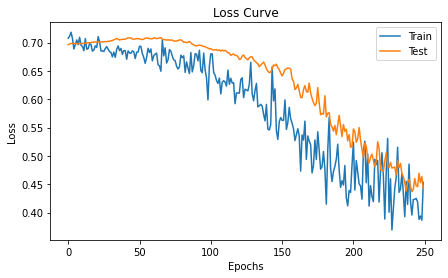

In [18]:
plt.figure(figsize = (7,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

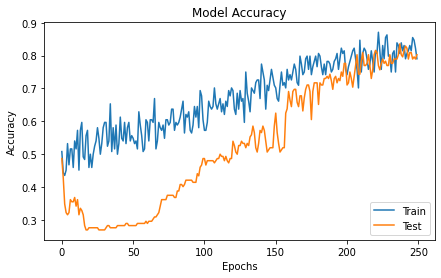

In [19]:
plt.figure(figsize = (7,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')

## Evaluating our Model

In [24]:
loss, accuracy = model.evaluate(test_generator)

2/2 [==============================] - 0s 43ms/step - loss: 0.5653 - accuracy: 0.8462


In [27]:
print(f"The accuracy received on Test data is: {accuracy*100:.2f}%")

The accuracy received on Test data is: 84.62%


---
Next we create a function to check our test our model.




In [37]:
from PIL import Image

def testModel(path, threshold=0.5):
  _img = Image.open(path)    # Visualizing the image
  _img.load()
  plt.xticks([])             # Disabling ticks
  plt.yticks([])
  plt.imshow(_img)

  # Converting the image so it can be fed into the model
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img)
  test_img = tf.image.resize(img, size = [img_width, img_height])    # Resize the image according to the model
  test_img = tf.image.rgb_to_grayscale(test_img)                     # Model expects a grayscale image
  test_img = test_img/255.                                           # Normalizing the image
  y_pred = model.predict(tf.expand_dims(test_img,axis=0))            # Model expects batches

  if (y_pred >= threshold):
    print(f"This is an image of Waleed.\n")
  else:
    print(f"This is NOT an image of Waleed.\n")

This is an image of Waleed.



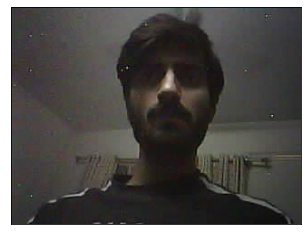

In [38]:
path = '/content/drive/MyDrive/test_Data/true/20220519221356.jpg'
testModel(path)

This is NOT an image of Waleed.



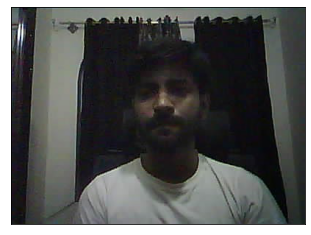

In [41]:
path = '/content/drive/MyDrive/test_Data/false/talha.jpg'
testModel(path)

## Converting our model to TF-lite
  Lastly, we convert our tensorflow model into a tf-lite model

In [43]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('cao.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpd5jvexe8/assets


INFO:tensorflow:Assets written to: /tmp/tmpd5jvexe8/assets


We need to convert our tf-lite model to a C++ array so it is readable for our micro-controller. 

In [42]:
!apt-get -qq install xxd
!xxd -i cao.tflite > model.cc

Selecting previously unselected package xxd.
(Reading database ... 155629 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
